## Setup

In [11]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [12]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'CloseDrawer'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [14]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [15]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([177, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([177]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([177, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([177, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([177, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([177, 3, 256, 256]), device=cpu, dt

In [16]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=10,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [17]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-03 11:28:23.980 | INFO     |  Fitting AutoTPGMM
2025-06-03 11:28:23.980 | INFO     |  Segmenting trajectories


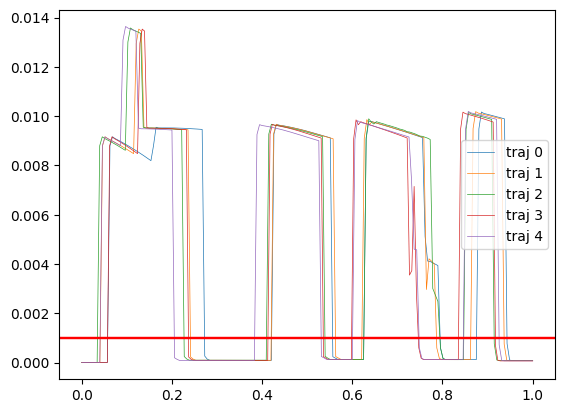

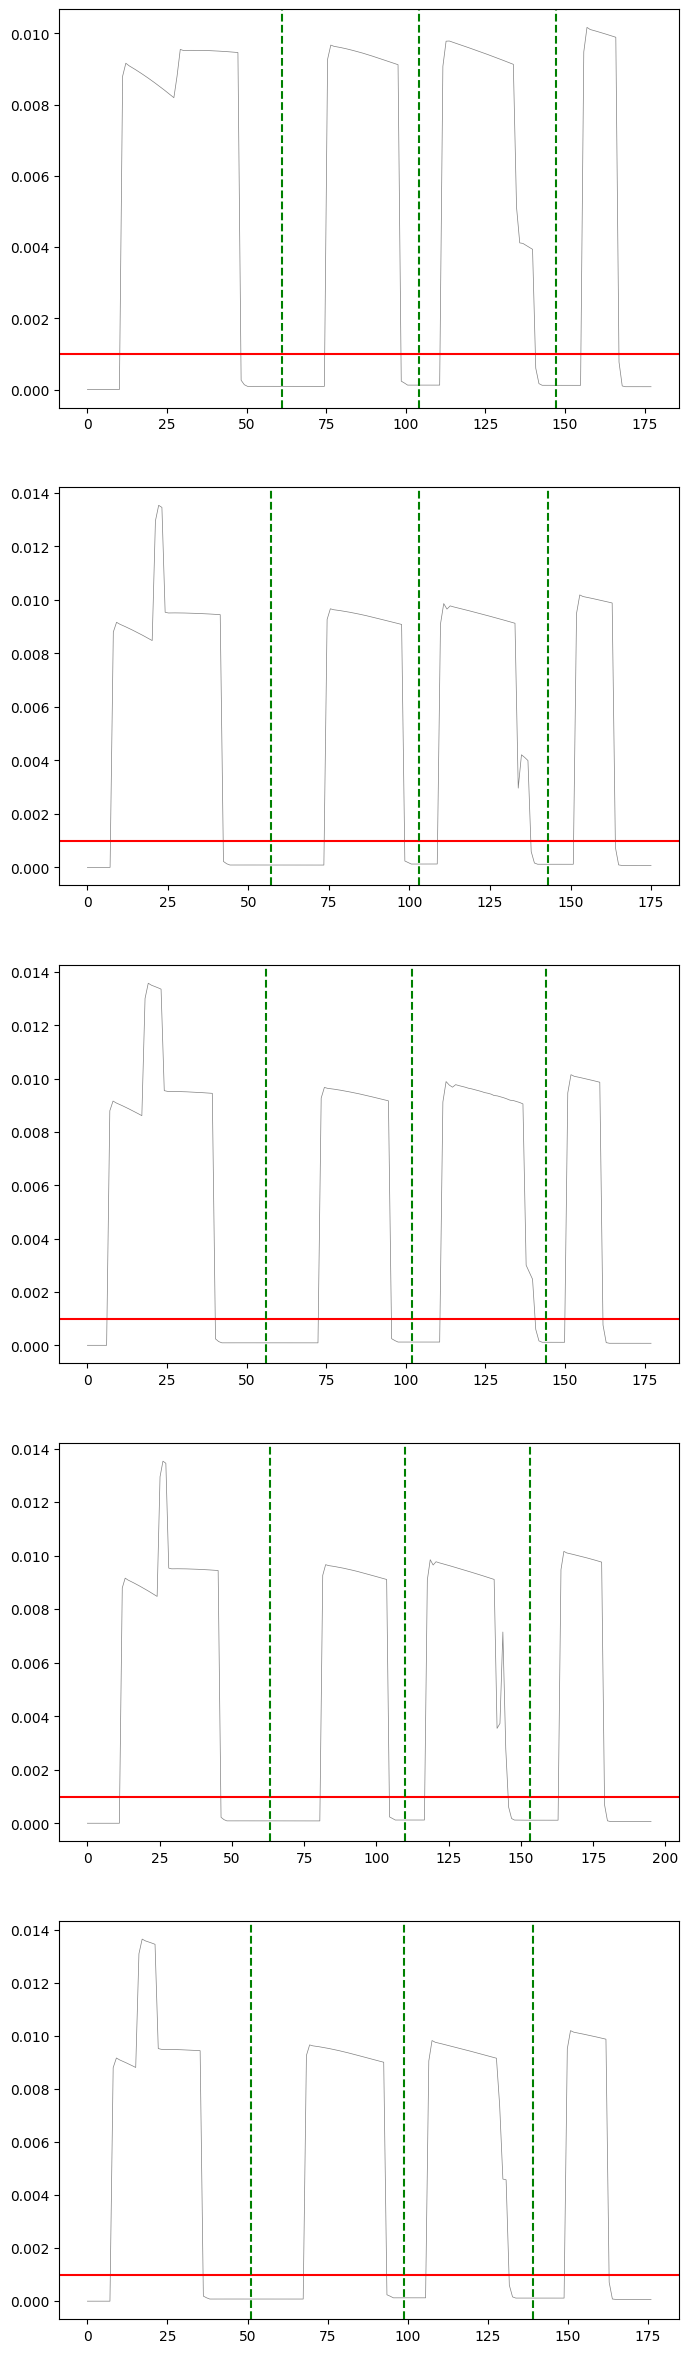

2025-06-03 11:28:25.018 | INFO     |  Creating segement of demos.
2025-06-03 11:28:25.025 | INFO     |  Subsampling to length 66 using strategy mean-length.
2025-06-03 11:28:25.027 | INFO     |  Creating segement of demos.
2025-06-03 11:28:25.037 | INFO     |  Creating segement of demos.
2025-06-03 11:28:25.048 | INFO     |  Creating segement of demos.
2025-06-03 11:28:25.057 | INFO     |  Subsampling to length 43 using strategy mean-length.
2025-06-03 11:28:25.058 | INFO     |  ... created 4 segments
2025-06-03 11:28:25.058 | INFO     |    Fitting candidate frame 1/10
2025-06-03 11:28:25.058 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:25.287 | INFO     |    Fitting candidate frame 2/10
2025-06-03 11:28:25.287 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:25.504 | INFO     |    Fitting candidate frame 3/10
2025-06-03 11:28:25.505 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:25.842 | INFO     |    Fitting candidate frame 4/10
2025-06-03 11:28:25.846 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:26.050 | INFO     |    Fitting candidate frame 5/10
2025-06-03 11:28:26.051 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:26.270 | INFO     |    Fitting candidate frame 6/10
2025-06-03 11:28:26.271 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:26.493 | INFO     |    Fitting candidate frame 7/10
2025-06-03 11:28:26.493 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:26.749 | INFO     |    Fitting candidate frame 8/10
2025-06-03 11:28:26.750 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:27.098 | INFO     |    Fitting candidate frame 9/10
2025-06-03 11:28:27.099 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:27.462 | INFO     |    Fitting candidate frame 10/10
2025-06-03 11:28:27.462 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:27.760 | INFO     |  Creating partial frame view of demos.
2025-06-03 11:28:27.763 | INFO     |    Fitting candidate frame 1/10
2025-06-03 11:28:27.763 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:27.979 | INFO     |    Fitting candidate frame 2/10
2025-06-03 11:28:27.979 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:28.244 | INFO     |    Fitting candidate frame 3/10
2025-06-03 11:28:28.245 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:28.492 | INFO     |    Fitting candidate frame 4/10
2025-06-03 11:28:28.493 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:28.727 | INFO     |    Fitting candidate frame 5/10
2025-06-03 11:28:28.728 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:28.965 | INFO     |    Fitting candidate frame 6/10
2025-06-03 11:28:28.966 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:29.222 | INFO     |    Fitting candidate frame 7/10
2025-06-03 11:28:29.223 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:29.450 | INFO     |    Fitting candidate frame 8/10
2025-06-03 11:28:29.451 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:29.764 | INFO     |    Fitting candidate frame 9/10
2025-06-03 11:28:29.764 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:30.076 | INFO     |    Fitting candidate frame 10/10
2025-06-03 11:28:30.076 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-03 11:28:30.375 | INFO     |  Creating partial frame view of demos.
2025-06-03 11:28:30.379 | INFO     |    Fitting candidate frame 1/10
2025-06-03 11:28:30.381 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:30.559 | INFO     |    Fitting candidate frame 2/10
2025-06-03 11:28:30.560 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:30.768 | INFO     |    Fitting candidate frame 3/10
2025-06-03 11:28:30.768 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:30.950 | INFO     |    Fitting candidate frame 4/10
2025-06-03 11:28:30.951 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:31.147 | INFO     |    Fitting candidate frame 5/10
2025-06-03 11:28:31.147 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:31.363 | INFO     |    Fitting candidate frame 6/10
2025-06-03 11:28:31.365 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:31.547 | INFO     |    Fitting candidate frame 7/10
2025-06-03 11:28:31.548 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:31.716 | INFO     |    Fitting candidate frame 8/10
2025-06-03 11:28:31.717 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:31.993 | INFO     |    Fitting candidate frame 9/10
2025-06-03 11:28:31.993 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:32.312 | INFO     |    Fitting candidate frame 10/10
2025-06-03 11:28:32.313 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:32.590 | INFO     |  Creating partial frame view of demos.
2025-06-03 11:28:32.592 | INFO     |    Fitting candidate frame 1/10
2025-06-03 11:28:32.593 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:32.729 | INFO     |    Fitting candidate frame 2/10
2025-06-03 11:28:32.729 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:32.868 | INFO     |    Fitting candidate frame 3/10
2025-06-03 11:28:32.869 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:33.098 | INFO     |    Fitting candidate frame 4/10
2025-06-03 11:28:33.099 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:33.355 | INFO     |    Fitting candidate frame 5/10
2025-06-03 11:28:33.356 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:33.560 | INFO     |    Fitting candidate frame 6/10
2025-06-03 11:28:33.561 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:33.707 | INFO     |    Fitting candidate frame 7/10
2025-06-03 11:28:33.708 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:33.850 | INFO     |    Fitting candidate frame 8/10
2025-06-03 11:28:33.850 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:34.120 | INFO     |    Fitting candidate frame 9/10
2025-06-03 11:28:34.121 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:34.364 | INFO     |    Fitting candidate frame 10/10
2025-06-03 11:28:34.365 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 11:28:34.575 | INFO     |  Creating partial frame view of demos.
2025-06-03 11:28:34.577 | INFO     |  Segmented trajs into 4 segments
2025-06-03 11:28:34.619 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142857 -0.142881 -0.142881 -0.142881 -0.142881 -0.142881   
Segment 1 -0.142853 -0.142860 -0.142860 -0.142860 -0.142860 -0.142860   
Segment 2 -0.142876 -0.142854 -0.142854 -0.142854 -0.142854 -0.142854   
Segment 3 -0.142850 -0.142858 -0.142858 -0.142858 -0.142858 -0.142858   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142881 -1.301825e-10 -4.777128e-10 -2.108703e-08  
Segment 1 -0.142860 -3.167555e-11 -1.337310e-10 -8.903883e-09  
Segment 2 -0.142854 -6.685919e-11 -5.381217e-10 -1.529720e-08  
Segment 3 -0.142858 -4.139780e-10 -2.448304e-09 -3.057790e-08  
2025-06-03 11:28:34.632 | INFO     |  Frame score (rel):
            ee_init   obj000   obj001   obj002   obj00

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-03 11:28:34.657 | INFO     |  Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[2.38e+013, 2.38e+013, 1.76e+013, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.41e+010, 5.18e+010, 9.86e+010, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.16e-033, 1.40e-032, 3.05e-032, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.16e-145, 3.37e-143, 3.29e-141, ..., 1.10e+010, 8.16e+009,
          5.53e+009]]),
  array([[9.89e+012, 9.86e+012, 7.75e+012, 4.81e+012, 2.35e+012, 9.08e+011,
          2.77e+011, 6.65e+010, 1.26e+010, 1.89e+009, 2.23e+008, 2.08e+007,
          1.53e+006, 8.85e+004, 4.04e+003, 1.46e+002, 1.58e+000, 2.11e-003,
          3.49e-007, 7.28e-012, 1.92e-017, 6.52e-024, 2.88e-031, 1.67e-039,
          1.30e-048, 1.36e-058, 1.93e-069, 3.90e-081, 6.49e-084, 1.47e-096,
          4.82e-110, 2.34e-124, 1.70e-139, 1.88e-155, 3.25e-172, 8.89e-190,
          3.92e-208, 2.82e-227, 3.37e-247, 6.79e-268, 8.80e-272, 1.34e-275,
          1.24e-279, 9.05e-284, 5.22e-288, 1.54e-292, 3.59e-297, 6.61e-302,
          9.59e-307, 1

In [18]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-03 11:28:36.094 | INFO     |  Did not specify time_based, deciding automatically.


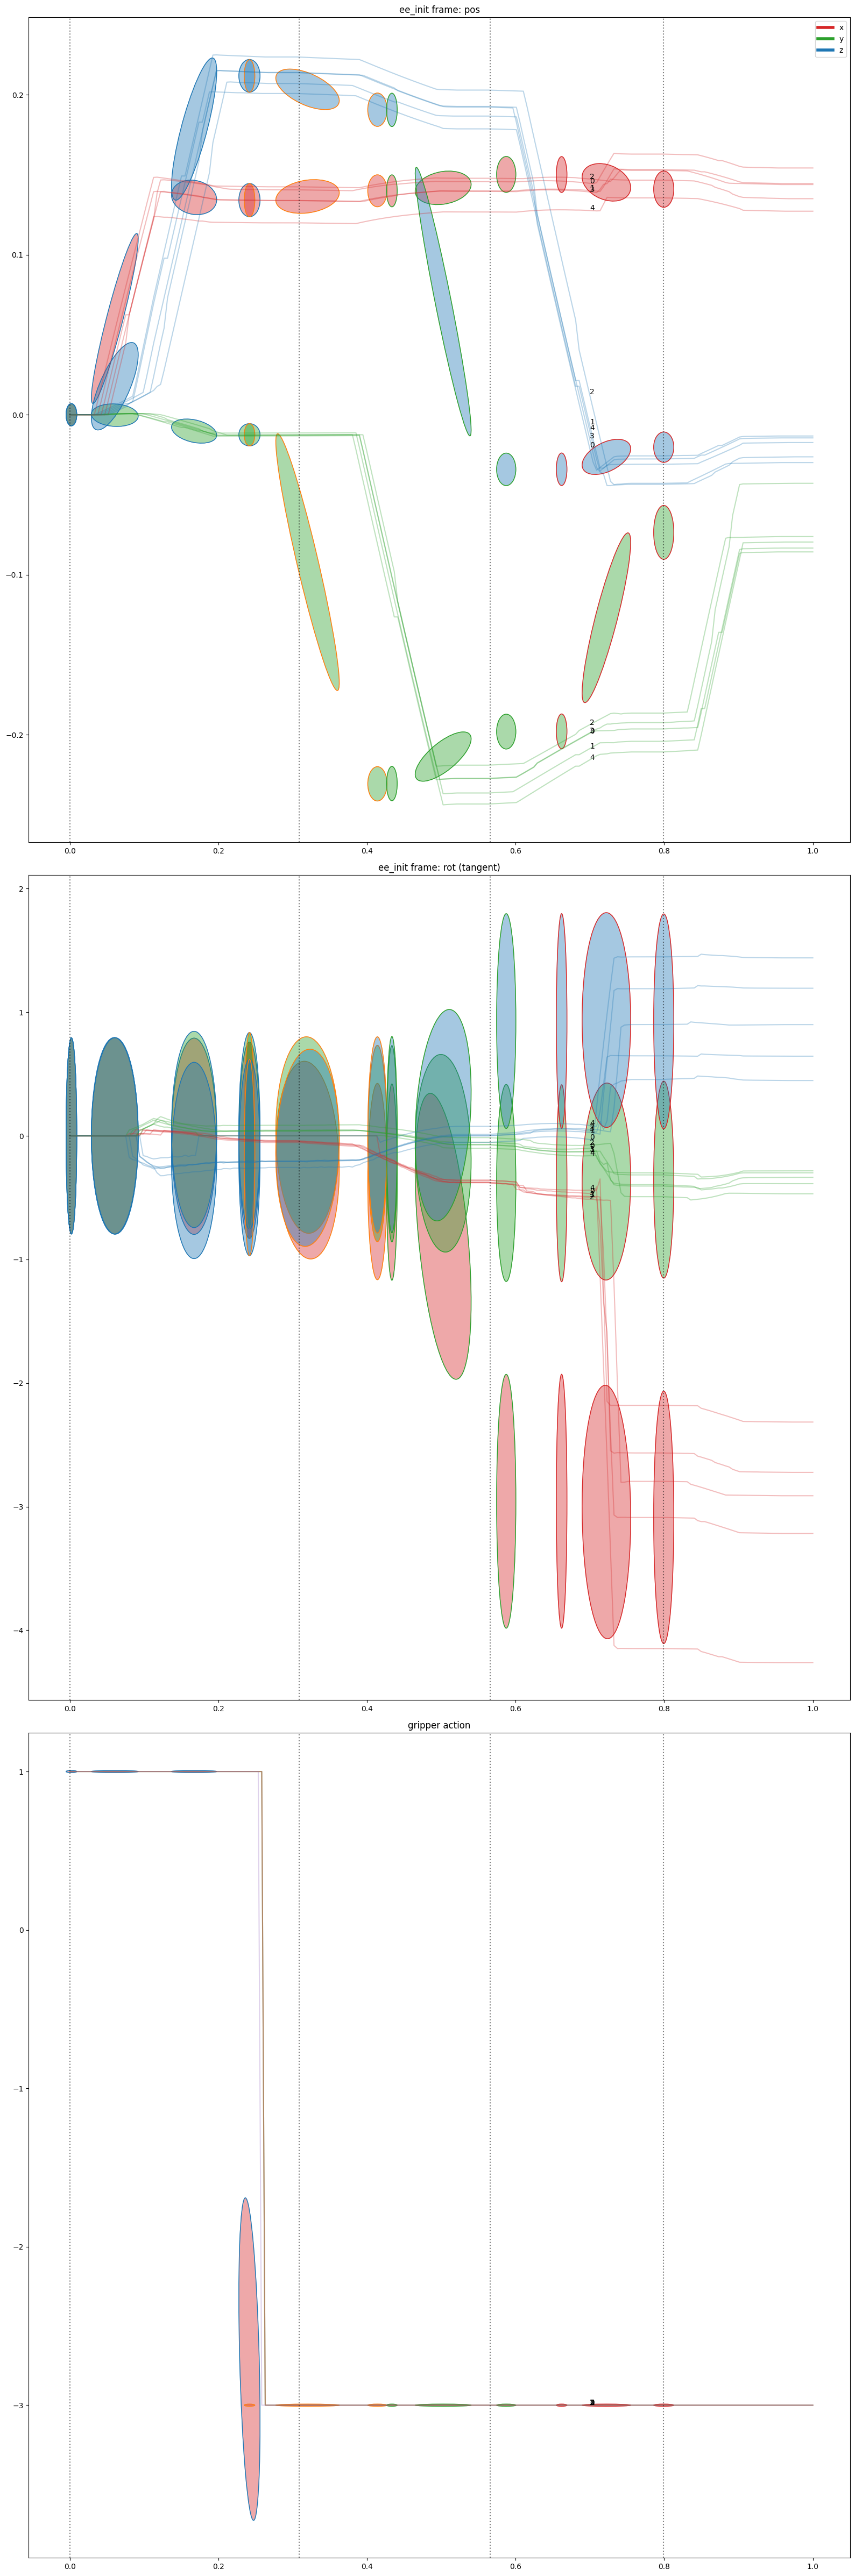

In [19]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [20]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-03 11:28:38.940 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-06-03 11:28:45.409 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 2.52e-31, 1.30e-25, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 9.97e-001, 8.77e-001, 2.81e-001, 9.39e-003,
          2.02e-005, 2.25e-009, 1.06e-014, 1.76e-021, 2.75e-030, 5.02e-042,
          1.37e-057, 7.20e-078, 9.38e-104, 3.99e-136, 7.33e-176, 7.83e-224,
          6.65e-281, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          

2025-06-03 11:28:51.616 | INFO     |  Did not specify time_based, deciding automatically.


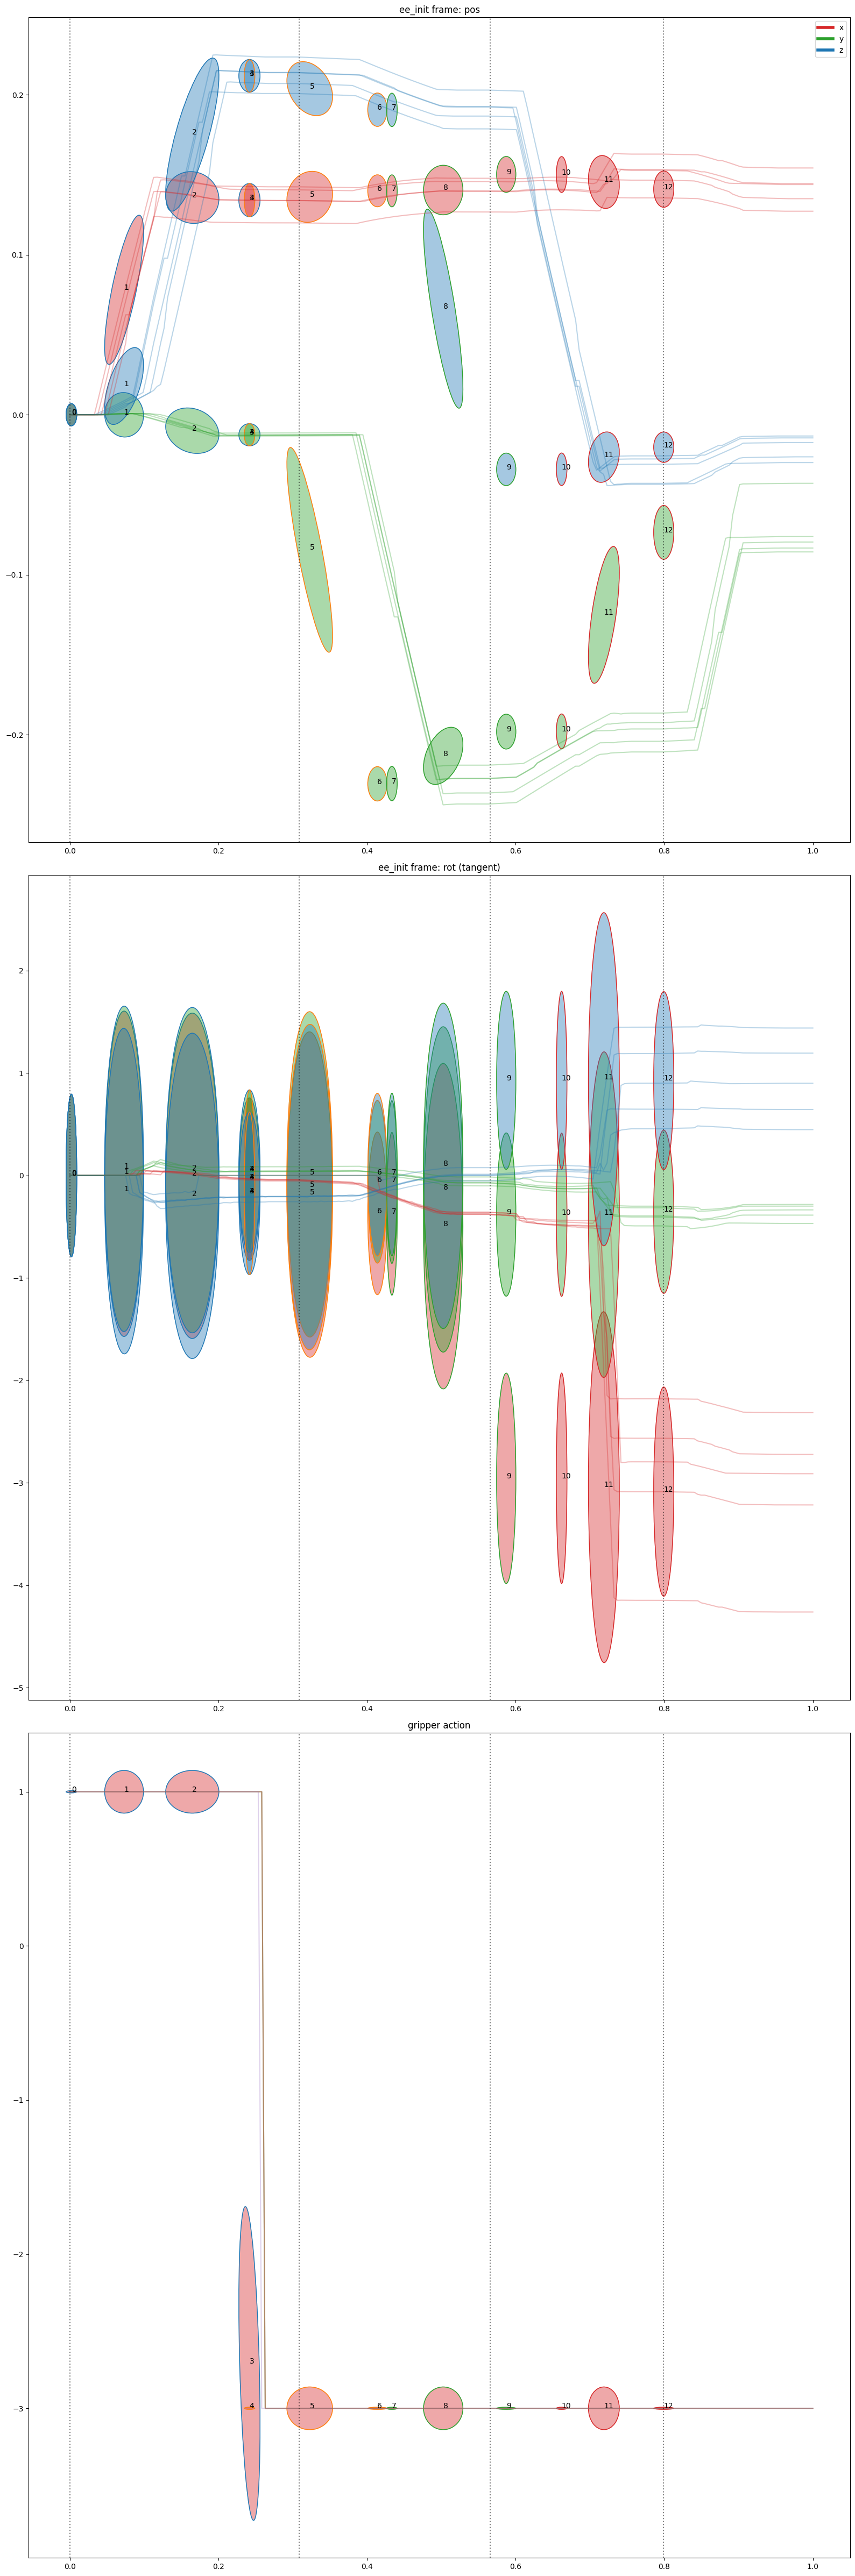

In [21]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

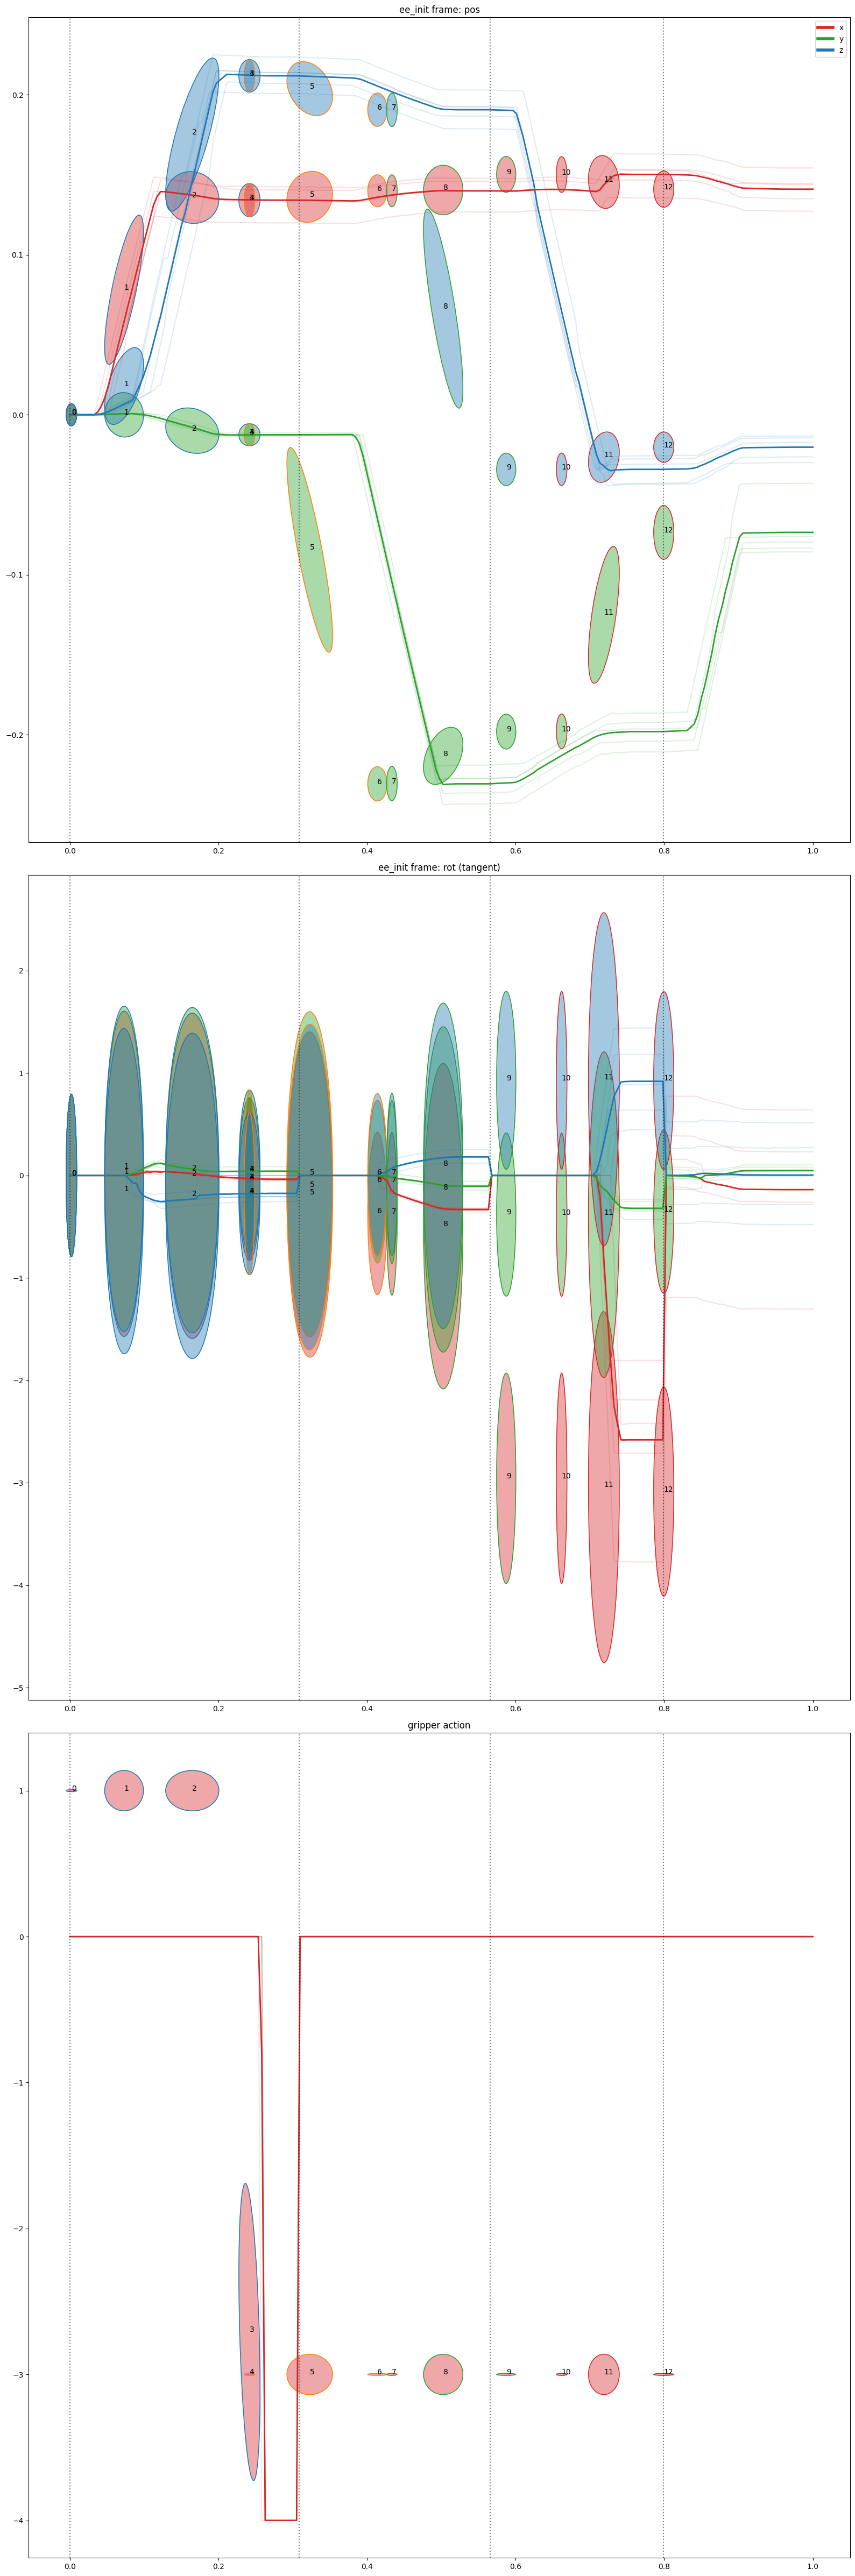

In [22]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

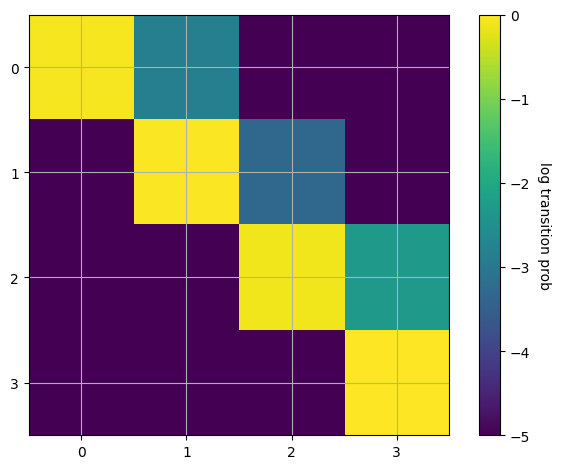

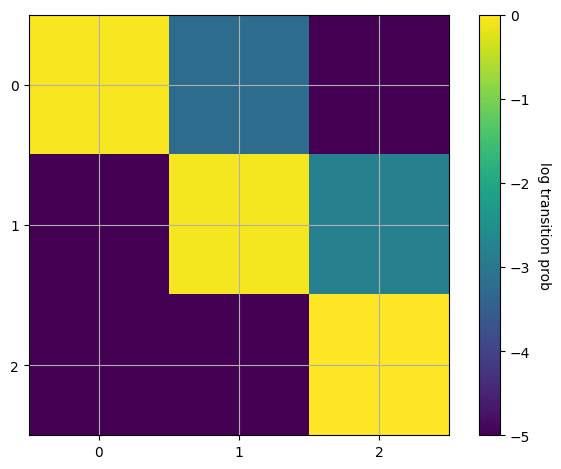

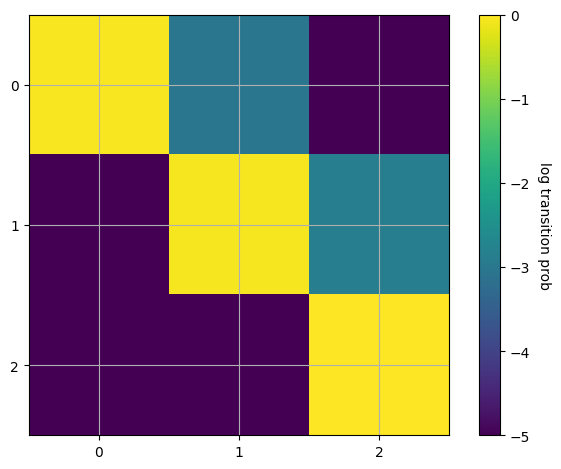

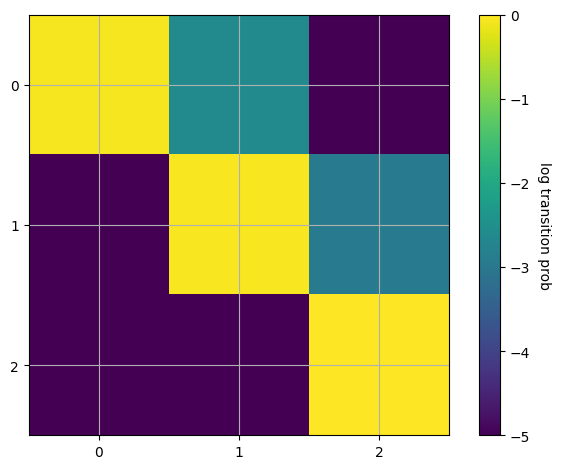

In [23]:
atpgmm.plot_hmm_transition_matrix()

In [24]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-06-03 11:28:57.719 | INFO     |  Saving model:


In [25]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-03 11:28:57.954 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-06-03 11:29:42.484 | INFO     |  Caculated segment transition probabilities: (array([[0.45]]), array([[0.02]]), array([[1.76e-23]]))
2025-06-03 11:29:42.484 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-06-03 11:29:42.484 | INFO     |  Creating partial frame view of demos.
2025-06-03 11:29:42.501 | INFO     |  Assuming zero frame velocity. Should be fixed.
(<riepybdlib.statistics.HMM object at 0x7fcc730ab6d0>,)


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-03 11:29:42.586 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7fcc730ab610>,)


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-03 11:29:42.654 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7fcc730181f0>,)


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-03 11:29:42.717 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7fcc7301ab30>,)


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-03 11:29:42.782 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

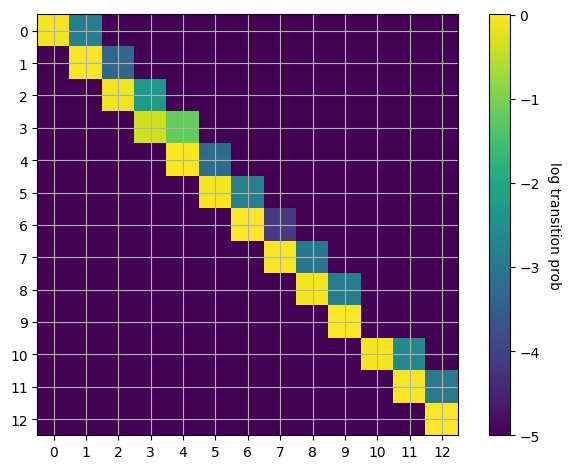

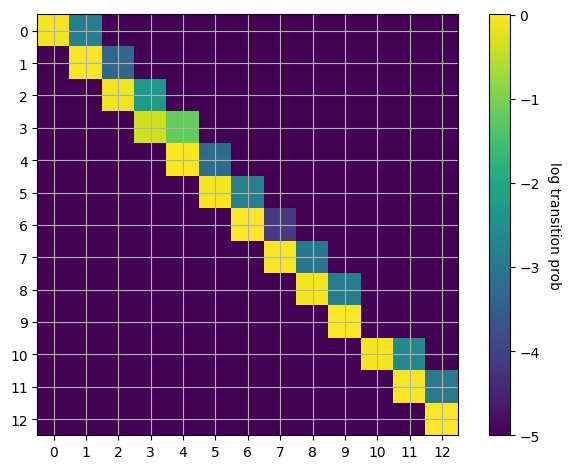

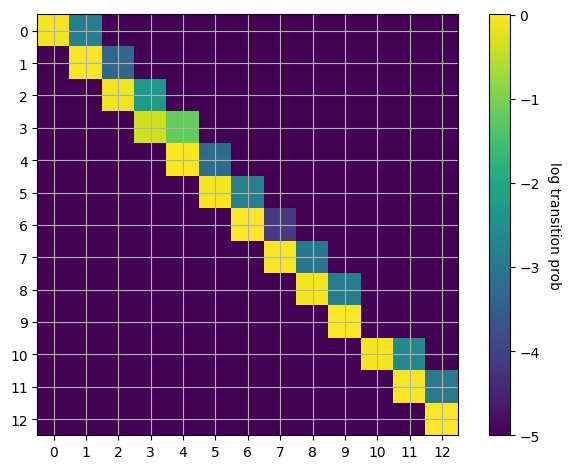

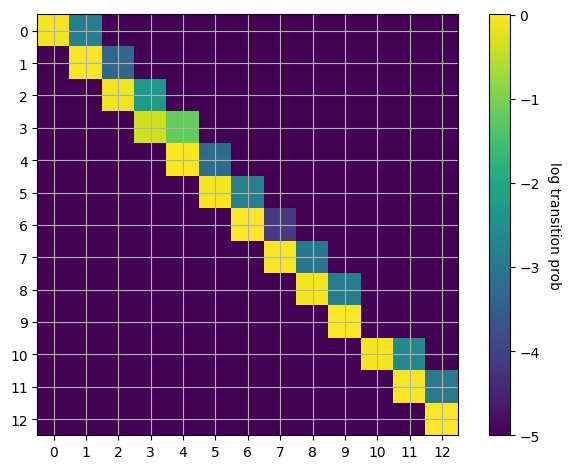

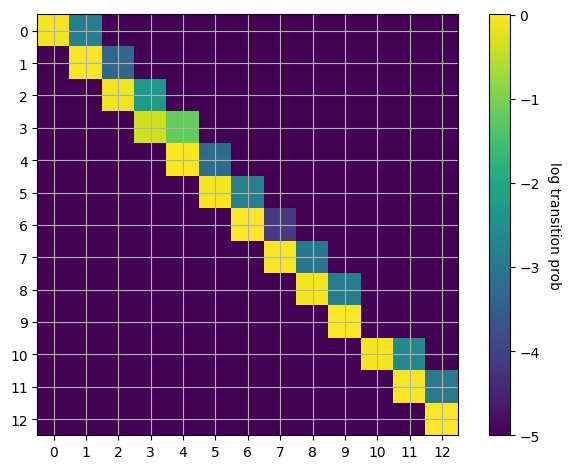

In [26]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-03 11:30:00.285 | INFO     |  Taking frame origins from demos.


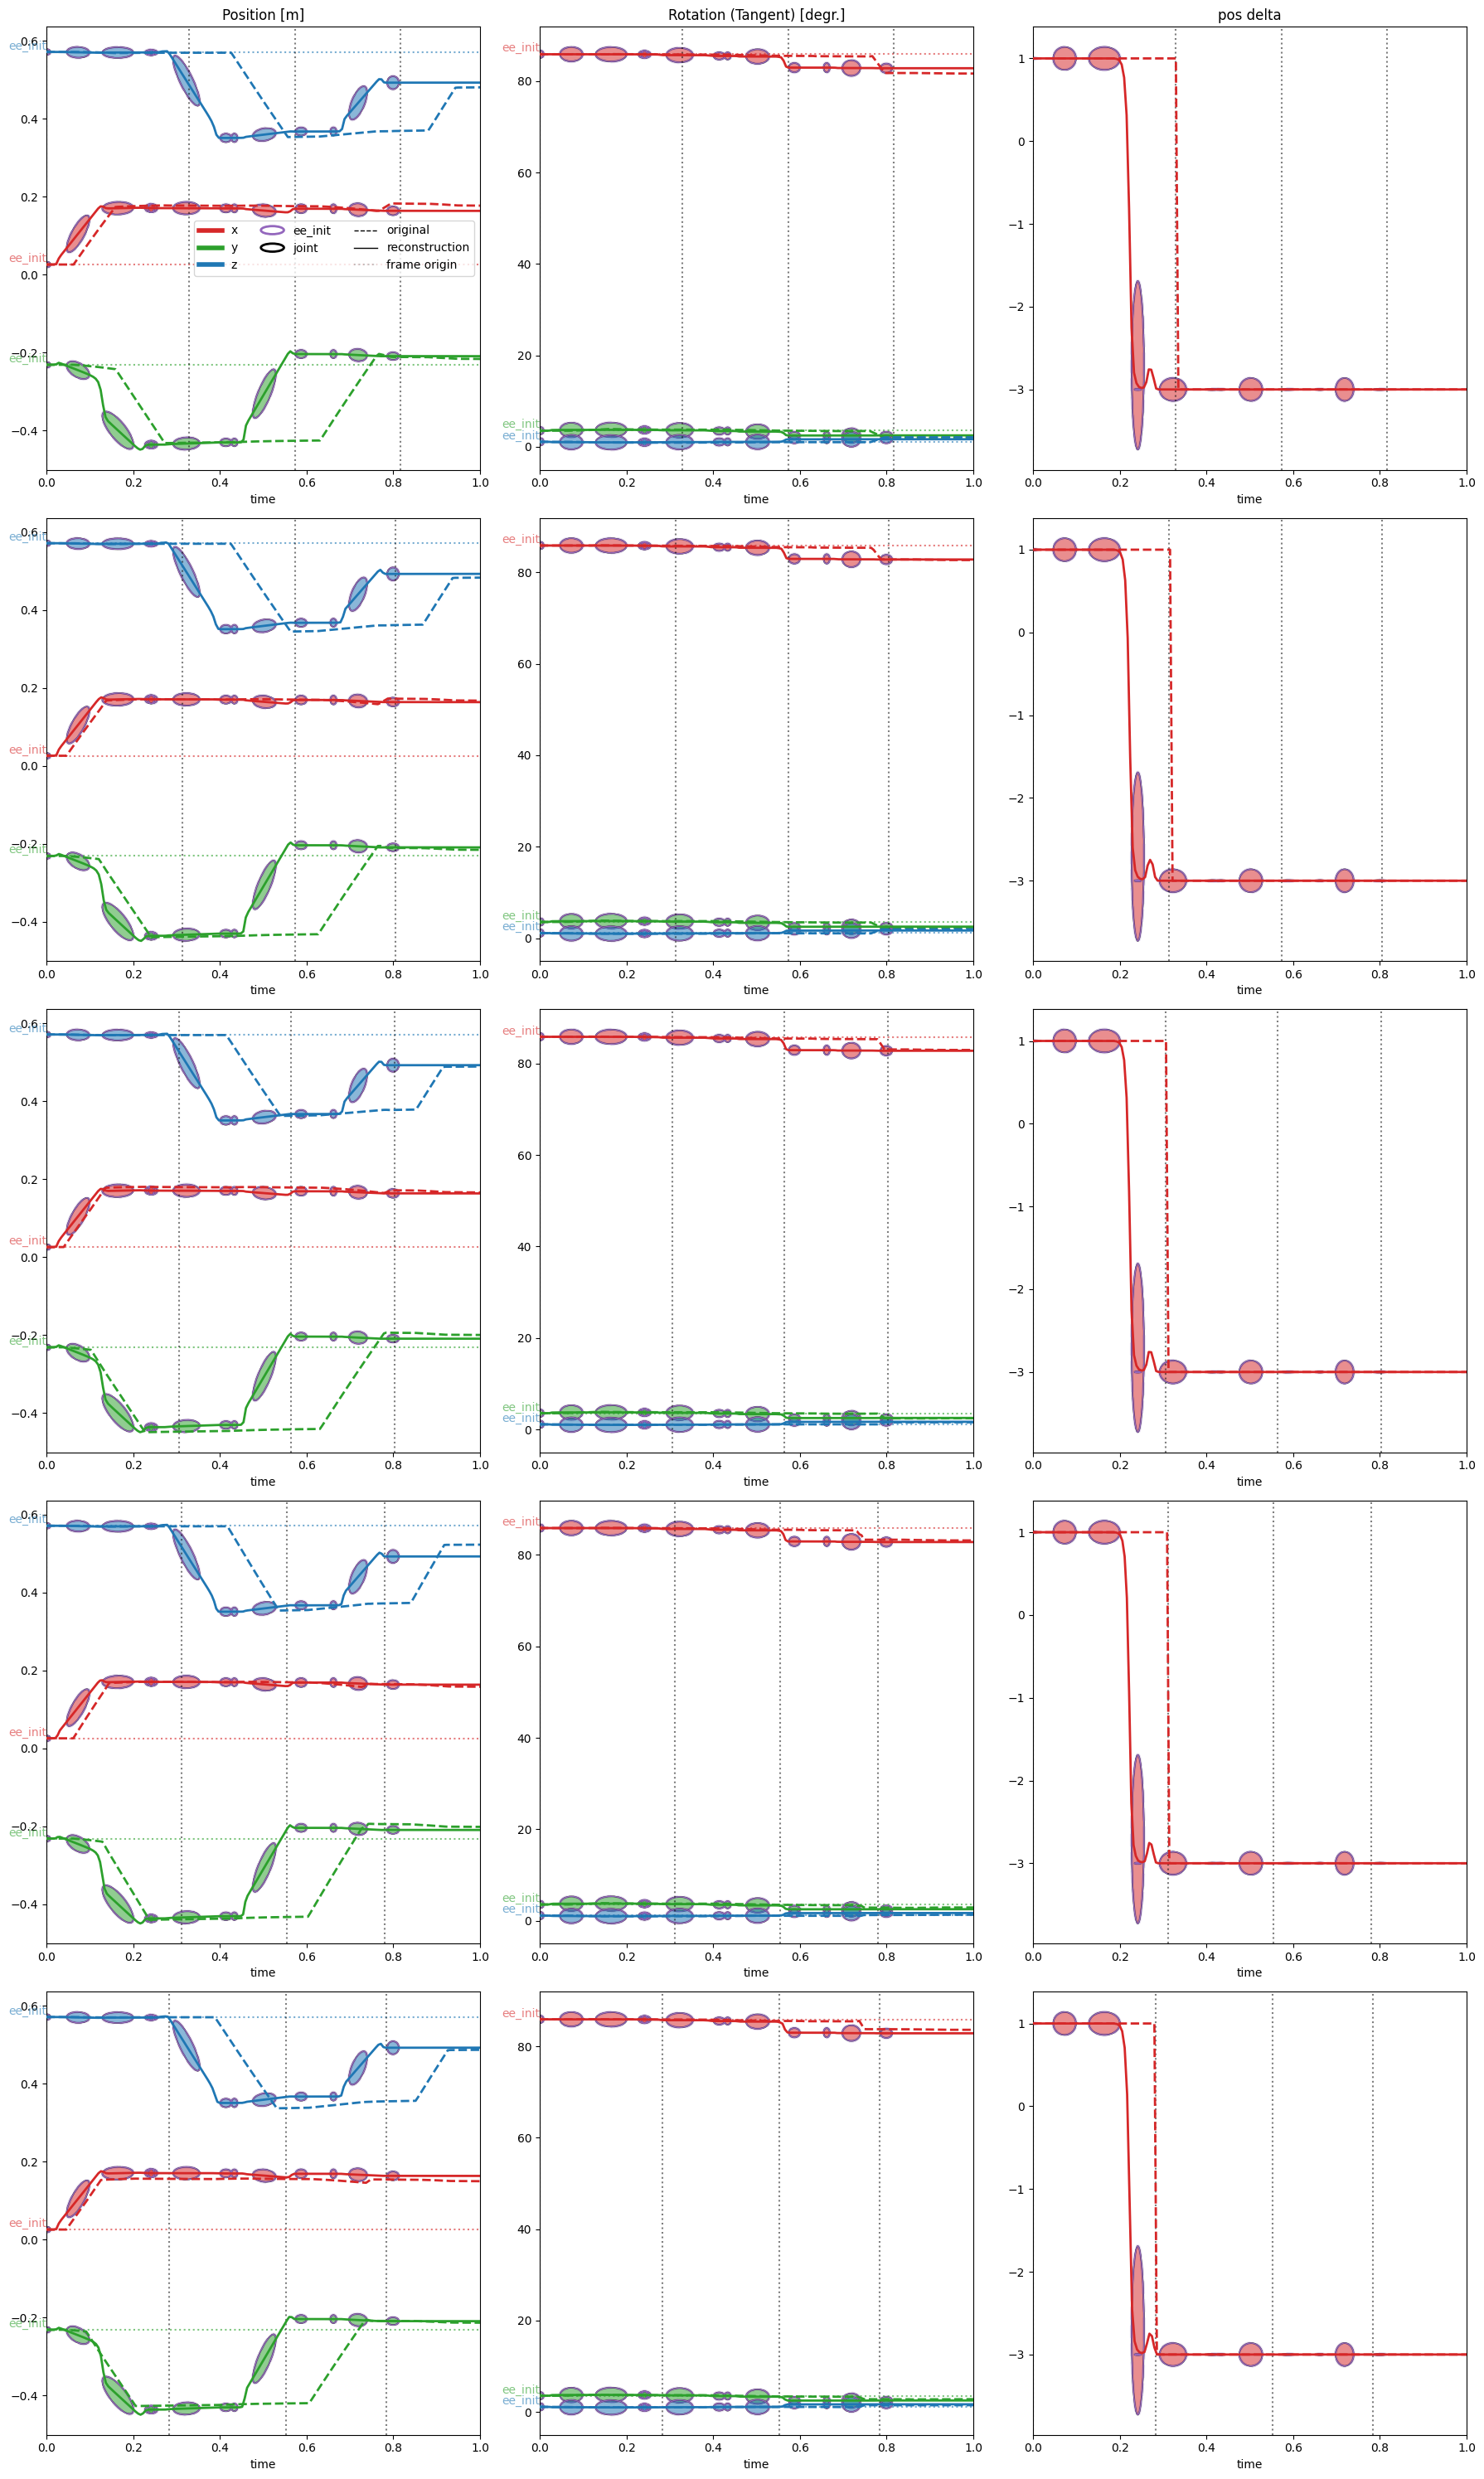

In [27]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [28]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-03 11:30:12.258 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'